# Import packages

In [2]:
import os
import lab3
from lab3.experiment.group import Mouse, ExperimentGroup
from lab3.experiment.base import BehaviorExperiment, ImagingExperiment, ImagingOnlyExperiment, fetch_trials
from lab3.experiment.virtual import VirtualBehaviorMixin
from lab3.analysis.spatial.abstract_spatial_tuning import SpatialTuning
from lab3.filters.time_filters import IsRunning
from lab3.signal.dfof import Suite2pDFOF
import matplotlib.pyplot as plt
from lab3.misc.progressbar import ProgressBar
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go
from scipy.signal import fftconvolve, gaussian
from sklearn import svm, metrics
from sklearn.model_selection import LeaveOneOut
np.set_printoptions(threshold=np.inf)
# ignore cvxpy warning

# Load experiment information

In [3]:
expt_mice = ['ek339']

In [4]:
#how many behavior sessions with this mouse
for m in expt_mice:
    mouse = Mouse.from_database(m, expt_class=BehaviorExperiment)
    
for i in range(len(mouse)):
    expt = mouse[i]
    print(i, expt.trial_id, expt.start_time)
    

0 41123 2025-04-07 15:20:10
1 41118 2025-04-07 15:25:10
2 41119 2025-04-13 12:35:47
3 41117 2025-04-15 15:28:29
4 41120 2025-04-15 15:49:20
5 41121 2025-04-15 15:59:58
6 41122 2025-04-17 17:31:01
7 41169 2025-04-18 15:44:57
8 41201 2025-04-22 15:30:39
9 41214 2025-04-22 15:30:39
10 41227 2025-04-24 14:51:26
11 41272 2025-04-26 12:56:44
12 41304 2025-04-28 11:43:14


In [5]:
expt = mouse[8] # corrupted signal #/data4/eunji/behaviorData/ek045/ek045_20230523125606.tdml (pkl)
print(expt.trial_id, expt.start_time)
bd_exp = expt.format_behavior_data()

41201 2025-04-22 15:30:39


In [ ]:
trial_id = 41227 #41201
sima_path = '/data4/eunji/imagingData/ek339/'
expt = ImagingExperiment(trial_id, sima_path=sima_path, force_pairing=True, store=True)

In [11]:
mouse = Mouse.from_database(trial_id= 41169,mouse_name = 'ek339',expt_class=ImagingExperiment)
expt = mouse[0]
bd_exp = expt.format_behavior_data()

In [12]:
###################################
# Extract event timeline
###################################
ctx_list = list(bd_exp['json']['contexts'].keys())

for i in range(len(bd_exp['json']['contexts'][ctx_list[0]]['decorators'])):
    if 'iti_time' in bd_exp['json']['contexts'][ctx_list[0]]['decorators'][i]:
        iti_time = bd_exp['json']['contexts'][ctx_list[0]]['decorators'][i]['iti_time']

laps = bd_exp['lap']
numLaps = bd_exp['json']['laps']

# find onset/offset during "vr_on" condition 
vr_on_start = []
vr_on_start = np.append(vr_on_start,laps[0])
for i in range(1,len(laps)-1):
    vr_on_start = np.append(vr_on_start, laps[i]+iti_time*10+1)
vr_on_start = vr_on_start.astype(int)

vr_on_end = laps[1:]

# find onset/offset during "vr_off" condition 
vr_off_start = laps[1:]
vr_off_end = laps[1:]+iti_time*10

events = pd.DataFrame({"vr_on_start":vr_on_start, "vr_on_end":vr_on_end, "vr_off_start":vr_off_start, "vr_off_end":vr_off_end })

# To exclude the last lap when it is incompletely done  
if events.loc[numLaps-1].max() > bd_exp['lap'][-1]: 
    events.drop(numLaps-1, axis=0, inplace=True)

In [13]:
events

,vr_on_start,vr_on_end,vr_off_start,vr_off_end
0,0,281,281,321
1,322,775,775,815
2,816,1092,1092,1132
3,1133,1330,1330,1370
4,1371,1756,1756,1796
...,...,...,...,...
91,25179,25343,25343,25383
92,25384,25608,25608,25648
93,25649,25831,25831,25871
94,25872,26080,26080,26120


In [14]:
# rw_loc = bd_exp['json']['contexts']['reward']['locations'][0]
# rw_rad = bd_exp['json']['contexts']['reward']['radius']
rw_dur = bd_exp['json']['contexts']['reward']['max_duration']

if 'water' in bd_exp.keys():
    water = bd_exp['water']

treadmillPosition = np.array(bd_exp['treadmillPosition'])
tracklength = bd_exp['json']['track_length']

if 'licking' in bd_exp.keys():
    licking = bd_exp['licking']
    lickstarts = np.array(bd_exp['licking'])
    numLicks = np.count_nonzero(bd_exp['licking'])
    lickpositions = treadmillPosition[lickstarts]*tracklength
else:
    licking = []
    lickstarts = []
    numLicks = 0
    lickpositions = treadmillPosition[lickstarts]*tracklength
velocity = bd_exp['velocity']

In [6]:
###################################
# Extract licking behavior information
###################################
vr_on_lick = []
vr_off_lick = []
for i in range(numLaps-1):
    vr_on_lick.append(lickstarts[events['vr_on_start'][i]:events['vr_on_end'][i]])
    vr_off_lick.append(lickstarts[events['vr_off_start'][i]:events['vr_off_end'][i]])
    
lick_info = pd.DataFrame({"vr_on":vr_on_lick, "vr_off":vr_off_lick})
lick_info

,vr_on,vr_off
0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, True, True..."
1,"[False, True, True, True, True, False, False, ...","[True, True, True, True, True, False, False, F..."
2,"[True, False, False, True, True, True, False, ...","[False, False, False, False, False, False, Fal..."
3,"[True, False, True, True, True, True, False, F...","[False, False, False, False, False, False, Fal..."
4,"[False, False, False, False, False, False, Fal...","[False, False, False, True, True, True, True, ..."
...,...,...
91,"[True, True, True, True, False, False, True, T...","[False, False, False, False, False, False, Fal..."
92,"[False, False, False, False, False, False, Fal...","[False, True, True, True, False, False, True, ..."
93,"[False, False, True, True, True, False, False,...","[False, False, False, False, False, False, Fal..."
94,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


In [7]:
############################################################
# Reconstructed treadmillPosition ("vr_on + vr_off" per lap)
############################################################
vr_on_treadmillPosition = []
vr_off_treadmillPosition = []
for i in range(numLaps-1):
    vr_on_treadmillPosition.append(treadmillPosition[events['vr_on_start'][i]:events['vr_on_end'][i]])
    
    curr_position = treadmillPosition[events['vr_off_start'][i]:events['vr_off_end'][i]]
    # To find the number of cycles during "vr_off" 
    iti_block = 1
    iti_block_offset = []
    for iti_frame in range(len(curr_position)-1):
        if curr_position[iti_frame]>0.9 and curr_position[iti_frame+1]<0.2:
            iti_block+=1
            iti_block_offset.append(iti_frame+1)

    # To reconstruc the position depending on the cycle number during "vr_off" 
    if iti_block == 0:
        vr_off_treadmillPosition.append(curr_position+1)
    else: #in the case of many cyles within ITI period #sometimes 2 cycles during 4s-ITI
        recon_curr_position = []
        for n in range(iti_block):
            # print(n)
            if n == len(iti_block_offset): # the last block (inclduing ITI-end)
                recon_curr_position.extend(curr_position[0:]+(n+1)*1)
            else:
                recon_curr_position.extend(curr_position[0:iti_block_offset[n]]+(n+1)*1)
                # print(recon_curr_position)
                curr_position = np.delete(curr_position,np.s_[0:iti_block_offset[n]],axis = None)
                # print('deleted')
                # print(curr_position)
        vr_off_treadmillPosition.append(np.array(recon_curr_position))
        
recon_treadmillPosition = pd.DataFrame({"vr_on":vr_on_treadmillPosition, "vr_off":vr_off_treadmillPosition})
recon_treadmillPosition

,vr_on,vr_off
0,"[0.0017647057771682738, 0.007058823108673095, ...","[1.000000244140625, 1.0058825969696046, 1.0105..."
1,"[0.16000015258789063, 0.16294132995605468, 0.1...","[1.0000049438476561, 1.0023578848838806, 1.004..."
2,"[0.04647551345825195, 0.04647551345825195, 0.0...","[1.0017643432617187, 1.0064702253341675, 1.012..."
3,"[0.04352906799316406, 0.04352906799316406, 0.0...","[1.0047052145004272, 1.0182346248626708, 1.028..."
4,"[0.5088231506347656, 0.51823486328125, 0.53117...","[1.0017673518657684, 1.0058849983215332, 1.010..."
...,...,...
91,"[0.025297908782958983, 0.025297908782958983, 0...","[1.00059033203125, 1.0152962131500245, 1.02823..."
92,"[0.5147083740234375, 0.52823779296875, 0.54176...","[1.0011780574321747, 1.0052957043647766, 1.009..."
93,"[0.01882511520385742, 0.01882511520385742, 0.0...","[1.0111772022247314, 1.0264713191986083, 1.038..."
94,"[0.6170596313476563, 0.6282361450195313, 0.642...","[1.0041186666488648, 1.0152951374053956, 1.025..."


In [8]:
###################################
# Licking position (vr_on + vr_off) - ver 3
###################################
vr_on_lick_pos = []
vr_off_lick_pos = []
for i in range(numLaps-1):
    curr_vr_on_lick_pos = recon_treadmillPosition['vr_on'][i]*lick_info['vr_on'][i]
    curr_vr_on_lick_pos = curr_vr_on_lick_pos[curr_vr_on_lick_pos!= 0.] # to prevent 0.0 being counted as location '0'
    vr_on_lick_pos.append(curr_vr_on_lick_pos*tracklength) 
    curr_vr_off_lick_pos = recon_treadmillPosition['vr_off'][i]*lick_info['vr_off'][i]
    curr_vr_off_lick_pos = curr_vr_off_lick_pos[curr_vr_off_lick_pos!=0.] # to prevent 0.0 being counted as location '0'
    vr_off_lick_pos.append(curr_vr_off_lick_pos*tracklength)

lick_pos = pd.DataFrame({"vr_on":vr_on_lick_pos, "vr_off":vr_off_lick_pos})
lick_pos

,vr_on,vr_off
0,"[87.6469497680664, 88.82341766357422, 752.9418...","[1022.9414176940919, 1026.4708290100098, 1030...."
1,"[162.9413299560547, 167.647216796875, 171.7648...","[1000.0049438476561, 1002.3578848838805, 1004...."
2,"[46.47551345825195, 47.06374740600586, 47.0637...","[1049.999641418457, 1049.4114074707031, 1049.4..."
3,"[43.52906799316406, 43.52906799316406, 43.5290...",[]
4,"[681.7645263671875, 687.05859375, 691.17620849...","[1012.9438219070435, 1015.884997367859, 1018.2..."
...,...,...
91,"[25.297908782958984, 25.297908782958984, 25.29...",[]
92,"[835.8831787109375, 841.1773071289062, 847.647...","[1005.2957043647766, 1009.41335105896, 1011.76..."
93,"[18.825115203857422, 19.41335105895996, 19.413...",[]
94,[],[]


(0.0, 1500.0)

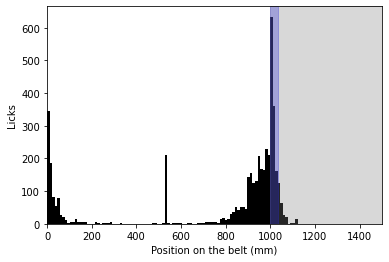

In [9]:
all_licks = []
for i in range(len(events)-1):
    all_licks.extend(np.concatenate([lick_pos['vr_on'][i],lick_pos['vr_off'][i]]))
    
y, x, _ = plt.hist(all_licks,100,color='black')
plt.axvspan(tracklength, tracklength + rw_dur*50, alpha=0.3, color='blue')
plt.axvspan(tracklength, tracklength*2, alpha=0.3, color='gray')
plt.ylabel('Licks')
plt.xlabel('Position on the belt (mm)')
plt.xlim([0,1500])
# plt.savefig('ek015_licking_histogram.png', dpi=300)

# Behavior Performance

In [10]:
R_ctx = ['ctxA', 'ctxB'] #user input
NR_ctx = ['ctxC', 'ctxD'] #user input
R_lap_list = []
NR_lap_list = []
for ctx_id in range(len(bd_exp['json']['contexts'])-1):
    ctx = (list(bd_exp['json']['contexts'].keys())[ctx_id])
    ctx_lap_list = bd_exp['json']['contexts'][ctx]['decorators'][0]['lap_list']
    if ctx in R_ctx:
        R_lap_list.extend(ctx_lap_list)
    else:
        NR_lap_list.extend(ctx_lap_list)
numRepeat = bd_exp['json']['contexts'][ctx]['decorators'][0]['repeat']

In [11]:
sequenceUnit = list(range(0,numRepeat))
stim_seq=sequenceUnit*((numLaps-1)//numRepeat) + sequenceUnit[0:numLaps-len(sequenceUnit*((numLaps-1)//numRepeat))-1]

In [12]:
##################Load or create DI_dataframe####################

ICRWL_file = os.path.join(expt.sima_path,"ICRWL.csv")
if os.path.isfile(ICRWL_file):
    print("ICRWL.h5 is successfully loaded")
    ICRWL = pd.read_csv(ICRWL_file)
else:
    ###################################
    # Which context is presented?
    ###################################
    ctx_info = []
    for i in range(numLaps-1):
        for ctx in R_ctx + NR_ctx:
            if np.sum(bd_exp[ctx][events['vr_on_start'][i]:events['vr_on_end'][i]]) != 0:
                ctx_info.append(ctx)   
                
    ###################################
    # Is this  reward or no-reward trial?
    ###################################
    r_or_nr = []
    for lap in range(numLaps-1):
        if stim_seq[lap] in R_lap_list:
            r_or_nr.append("True")
        else:
            r_or_nr.append("False")

    ###################################
    # Extract water information
    ###################################
    vr_on_water = []
    vr_off_water = []
    getWater = [] #whether water reward come or not
    for i in range(numLaps-1):
        if True in water[events['vr_off_start'][i]:events['vr_off_end'][i]]:
            getWater.append("True")
        else:
            getWater.append("False")
            
        vr_on_water.append(water[events['vr_on_start'][i]:events['vr_on_end'][i]])
        vr_off_water.append(water[events['vr_off_start'][i]:events['vr_off_end'][i]])
        
    water_info = pd.DataFrame({"vr_on":vr_on_water, "vr_off":vr_off_water})

    ###################################
    # licking behavior during RZ
    ###################################
    lick_or_not = []
    for i in range(numLaps-1):
        if len(lick_pos['vr_off'][i]) == 0:
            lick_or_not.append("False")
        else:
            lick_or_not.append("True")

    # Generate a behavior summary table -- ICRWL: lap_index, context, reward_trial, water, lick_or_not
    ICRWL = pd.DataFrame({"lap_index":stim_seq, "context":ctx_info,"reward_trial":r_or_nr,"water":getWater, "lick_or_not":lick_or_not})
    ICRWL.to_csv(ICRWL_file)
    print("ICRWL created")
################################################################


ICRWL.h5 is successfully loaded


In [13]:
# Validate trial result - hit / miss / false alarm / correct rejection
hit_idx = []
miss_idx = []
falseAlarm_idx =[]
corrRej_idx = []
for i in range(numLaps-1):
    if ICRWL['reward_trial'][i] == 'True' and ICRWL['water'][i] == 'True':
        hit_idx.append(i)
    elif ICRWL['reward_trial'][i] == 'True' and ICRWL['water'][i] == 'False':
        miss_idx.append(i)
    elif ICRWL['reward_trial'][i] == 'False' and ICRWL['lick_or_not'][i] == 'True':
        falseAlarm_idx.append(i)
    elif ICRWL['reward_trial'][i] == 'False' and ICRWL['lick_or_not'][i] == 'False':
        corrRej_idx.append(i)

In [14]:
# Validate trial result - hit / miss / false alarm / correct rejection
hit_idx = []
miss_idx = []
falseAlarm_idx =[]
corrRej_idx = []
for i in range(numLaps-1):
    if ICRWL['reward_trial'][i] == True and ICRWL['water'][i] == True:
        hit_idx.append(i)
    elif ICRWL['reward_trial'][i] == True and ICRWL['water'][i] == False:
        miss_idx.append(i)
    elif ICRWL['reward_trial'][i] == False and ICRWL['lick_or_not'][i] == True:
        falseAlarm_idx.append(i)
    elif ICRWL['reward_trial'][i] == False and ICRWL['lick_or_not'][i] == False:
        corrRej_idx.append(i)

In [15]:
print("numHit = %d, numMiss = %d, numFA = %d, numCR = %d" %(len(hit_idx),len(miss_idx), len(falseAlarm_idx), len(corrRej_idx)))
corr_rate = (len(hit_idx)+len(corrRej_idx))/len(ICRWL)
print("Correct rate at %s is %6.4f" %((expt.start_time), float(corr_rate)))

numHit = 48, numMiss = 0, numFA = 1, numCR = 47
Correct rate at 2025-04-18 15:44:57 is 0.9896


NameError: name 'expt_mice' is not defined

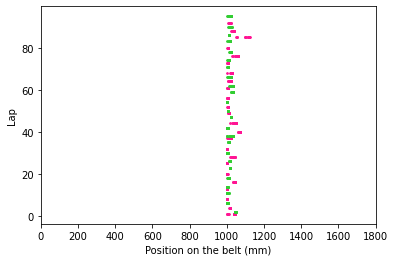

In [16]:
for i in range(numLaps-1):
    if ICRWL['context'][i] == R_ctx[0]: 
        x = lick_pos['vr_off'][i]
        y = np.ones((len(x),), dtype=int)*i
        plt.scatter(x,y,s=3, c='deeppink')
    elif ICRWL['context'][i] == R_ctx[1]: 
        x = lick_pos['vr_off'][i]
        y = np.ones((len(x),), dtype=int)*i
        plt.scatter(x,y,s=3, c='limegreen')
    
plt.xlim([0,1800])
plt.xlabel('Position on the belt (mm)')
plt.ylabel('Lap')
plt.title(expt_mice)
# plt.show()
# plt.savefig('ne001_230223_licking.png', dpi=300)

# Load calcium imaging data

In [17]:
def get_place_maps(expt, n_position_bins=100, sigma=3,
                       velocity_threshold=5):
    # Find frames_to_include
    beh_data = expt.format_behavior_data()
    laps = beh_data['lap_bin']
    velocity = beh_data['velocity']
    licking = beh_data['licking']

    ctx_id = beh_data['ctxA'].astype('int')\
    -beh_data['ctxB'].astype('int')\
    -beh_data['ctxC'].astype('int')\
    -beh_data['ctxD'].astype('int')
    iti = ctx_id == 0

    # extend ITI by one frame to correct an error in behavior data formatting
    iti[np.where(np.diff(iti.astype('int'))==-1)[0] + 1] = True

    # discretize position into n_position_bins bins
    pos = (beh_data['treadmillPosition'] * n_position_bins).astype('int')

    # load dfof
    dfof = expt.signals(label='suite2p', signal_type='dfof')

    # iterate over laps to create spatial tuning array
    print(f'Calculation spatial rasters for {expt}')

    place_maps = np.zeros((len(np.unique(laps)), dfof.shape[0], 
                       n_position_bins))
    p = ProgressBar(len(np.unique(laps)) )
    for lap in range(len(np.unique(laps))):

        # only count signals on the current lap while the animal is 
        # running > velocity_threshold cm/sec, and not during ITI periods 
        valid_samples = (laps==lap) & ~iti & (velocity > velocity_threshold) & ~licking

        # calculate spike rate at each position
        place_maps[lap, :] = np.stack(
            [np.mean(dfof.iloc[:, (valid_samples) & (pos==p)], axis=1) 
             for p in range(n_position_bins)]).T

        p.update(lap)
    p.end()

    # replace nans with zeros and smooth with a gaussian
    place_maps = np.nan_to_num(np.swapaxes(place_maps, 0, 1))
    k = gaussian(12, sigma)
    k /= k.sum()
    smooth_place_maps = np.apply_along_axis(fftconvolve, -1, place_maps, k, mode='same') 
    
    return place_maps, smooth_place_maps

In [18]:
##################Load or create place maps####################
place_maps_file = os.path.join(expt.sima_path,"place_maps.pkl")
if os.path.isfile(place_maps_file):
    with open(place_maps_file,'rb') as f:
        place_maps_dict = pickle.load(f)
    print("place_maps.pkl is successfully loaded")
    
    place_maps = place_maps_dict['raw']
    smooth_place_maps = place_maps_dict['smooth']
else:
    with open(place_maps_file,'wb') as f:
        place_maps, smooth_place_maps = get_place_maps(expt)
        place_maps_dict={"raw":place_maps,"smooth":smooth_place_maps}
        pickle.dump(place_maps_dict,f) 
    print("place_maps.pkl created")
################################################################

place_maps.pkl is successfully loaded


In [80]:
def SVM_decoding(rasters,ctx_id):
    """To do:
    update "rasters" to extract dff information from specific cell population such as neurons with significant d' value

    IDEA:
    if not n_list:
        rasters = rasters
    elif n_list = signif_n_list: # should load ctx_A_signif_idx and ctx_B_signif_idx from DI.h5 file
        rasters = rasters[signif_n_list,:,:]
    """
    loo = LeaveOneOut()
    X = np.arange(0,len(ctx_id)) #Number of trials

    Accuracy = []

    p = ProgressBar(rasters.shape[2])
    for spatial_bin in range(rasters.shape[2]): #iterate every spatial_bin (e.g. n_position_bins = 100)
        accuracy = []
        for i, (train_index, test_index) in enumerate(loo.split(X)): #i-th fold
            # Splitting Data
            X_train = np.transpose(rasters[:,train_index,spatial_bin],(1,0)) #input dataframe in (num_lap x num_neuron) dimension
            X_test = np.transpose(rasters[:,test_index,spatial_bin],(1,0)) #input dataframe in (num_lap x num_neuron) dimension
            y_train = ctx_id[train_index] 
            y_test = ctx_id[test_index] 

            # Generating Model
            # Create a SVM Classifier
            clf = svm.SVC(kernel='linear') # linear kernel

            # Train the model using training sets
            clf.fit(X_train, y_train)

            # Predict the response for test dataset
            y_pred = clf.predict(X_test)

            # Evaluating the Model
            if np.array_equal(y_test,y_pred):
                accuracy.append(1)
            else:
                accuracy.append(0)
        Accuracy.append(np.mean(np.array(accuracy)))    
        p.update(spatial_bin)
    p.end
    Accuracy = np.array(Accuracy)
    return Accuracy

In [81]:
ctx_id = ICRWL['context']
R_indices = ICRWL.index[ICRWL['reward_trial'] == True].tolist()
NR_indices = ICRWL.index[ICRWL['reward_trial'] == False].tolist()
R_rasters = smooth_place_maps[:,R_indices,:]
NR_rasters = smooth_place_maps[:,NR_indices,:]
R_ctx_id = np.array(ctx_id[R_indices])
NR_ctx_id = np.array(ctx_id[NR_indices])

In [35]:
Accuracy_R = SVM_decoding(R_rasters, R_ctx_id)
Accuracy_NR = SVM_decoding(NR_rasters, NR_ctx_id)

	[=================== ] 99%

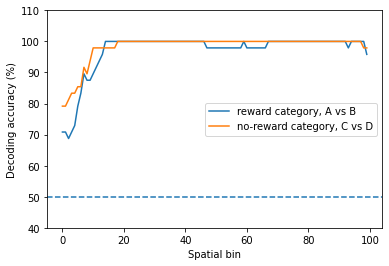

In [40]:
plt.plot(Accuracy_R*100, label='reward category, A vs B')
plt.plot(Accuracy_NR*100, label='no-reward category, C vs D')
plt.legend()
plt.ylabel('Decoding accuracy (%)')
plt.xlabel('Spatial bin')
plt.ylim([40,110])
plt.axhline(y=50, linestyle='--')

In [32]:
print(smooth_place_maps.shape)
print(context_labels.shape)
len(context_labels)

(562, 98, 100)


NameError: name 'context_labels' is not defined

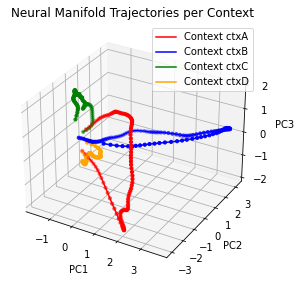

In [97]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Combine all rasters (rewarded and non-rewarded, or choose one)
context_labels = np.array(ctx_id)  # array of context labels, shape: [n_trials]
rasters = smooth_place_maps[:,:len(context_labels),:]  # shape: [n_neurons, n_trials, n_bins]

# 2. Get unique contexts
unique_ctx = np.unique(context_labels)
n_bins = rasters.shape[2]

# 3. Compute mean activity per context per bin
mean_activity = []
for ctx in unique_ctx:
    ctx_trials = rasters[:, context_labels == ctx, :]  # [n_neurons, n_ctx_trials, n_bins]
    ctx_mean = np.mean(ctx_trials, axis=1)  # mean across trials -> [n_neurons, n_bins]
    mean_activity.append(ctx_mean.T)  # transpose to [n_bins, n_neurons]

# Stack into shape: [n_contexts * n_bins, n_neurons]
all_means = np.vstack(mean_activity)  # shape: [n_ctx * n_bins, n_neurons]

# 4. Apply PCA
pca = PCA(n_components=3)
pca_proj = pca.fit_transform(all_means)  # shape: [n_ctx * n_bins, 3]

# 5. Split back and plot
colors = ['red', 'blue', 'green', 'orange']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, ctx in enumerate(unique_ctx):
    start = i * n_bins
    end = (i + 1) * n_bins
    traj = pca_proj[start:end]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f'Context {ctx}', color=colors[i])
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], s=10, color=colors[i])

ax.set_title("Neural Manifold Trajectories per Context")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()

# ax.view_init(elev=30, azim=60)  # You can adjust these numbers
plt.tight_layout()
output_file = expt.sima_path + '/manifold_context_trajectory.pdf'
plt.savefig(output_file)


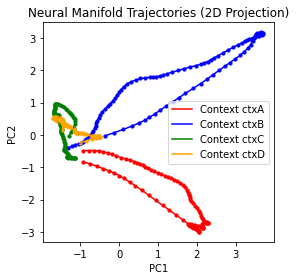

In [101]:
# 5. Split back and plot 2D projection (PC1 vs PC2)
colors = ['red', 'blue', 'green', 'orange']
fig, ax = plt.subplots(figsize=(4, 4))

for i, ctx in enumerate(unique_ctx):
    start = i * n_bins
    end = (i + 1) * n_bins
    traj = pca_proj[start:end]
    ax.plot(traj[:, 0], traj[:, 1], label=f'Context {ctx}', color=colors[i])
    ax.scatter(traj[:, 0], traj[:, 1], s=10, color=colors[i])

ax.set_title("Neural Manifold Trajectories (2D Projection)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

plt.tight_layout()
output_file = expt.sima_path + '/manifold_context_trajectory_2D.pdf'
plt.savefig(output_file)


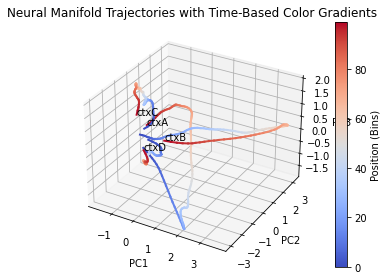

In [98]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Custom gradient colormaps for each context
context_cmaps = {
    'A': LinearSegmentedColormap.from_list('pink_grad', ['pink', 'deeppink']),
    'B': LinearSegmentedColormap.from_list('green_grad', ['lightgreen', 'darkgreen']),
    'C': LinearSegmentedColormap.from_list('yellow_grad', ['gold', 'orange']),
    'D': LinearSegmentedColormap.from_list('purple_grad', ['mediumpurple', 'indigo'])
}

# 1. Combine all rasters and context labels
rasters = smooth_place_maps[:,:len(ctx_id),:]  # [n_neurons, n_trials, n_bins]
context_labels = np.array(ctx_id)  # shape: [n_trials]
unique_ctx = np.unique(context_labels)
n_bins = rasters.shape[2]

# 2. Compute mean activity per context per bin
mean_activity = []
for ctx in unique_ctx:
    ctx_trials = rasters[:, context_labels == ctx, :]
    ctx_mean = np.mean(ctx_trials, axis=1).T  # [bins, neurons]
    mean_activity.append(ctx_mean)

# 3. Stack and PCA
all_means = np.vstack(mean_activity)  # [ctx * bins, neurons]
pca = PCA(n_components=3)
pca_proj = pca.fit_transform(all_means)

# 4. Plot with gradient colors per context, based on time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a ScalarMappable for colorbar (mapping time to color)
norm = mpl.colors.Normalize(vmin=0, vmax=n_bins - 1)  # Normalize the time (bins)
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)  # Using 'viridis' for the colorbar, adjust to your colormap
sm.set_array([])  # Empty array because we don't need data for the colorbar

for i, ctx in enumerate(unique_ctx):
    cmap = context_cmaps.get(ctx, plt.cm.coolwarm)  # Get the colormap for each context
    start = i * n_bins
    end = (i + 1) * n_bins
    traj = pca_proj[start:end]  # [bins, 3]

    # For each time step in the trajectory, color it based on time using the gradient
    for t in range(n_bins - 1):
        ax.plot(
            traj[t:t+2, 0], traj[t:t+2, 1], traj[t:t+2, 2], 
            color=cmap(t / (n_bins - 1)), linewidth=2
        )

    # Optional: label the last point of the trajectory
    ax.text(traj[-1, 0], traj[-1, 1], traj[-1, 2], f'{ctx}', fontsize=10)

# Add the colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Position (Bins)')

# Set labels and title
ax.set_title("Neural Manifold Trajectories with Time-Based Color Gradients")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
# plt.show()
output_file = expt.sima_path + '/manifold_time_trajectory.pdf'
plt.savefig(output_file)



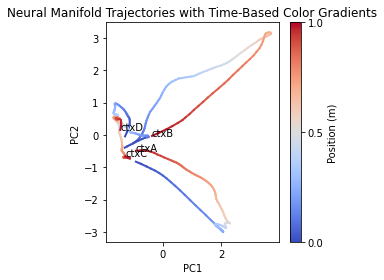

In [99]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Custom gradient colormaps for each context
context_cmaps = {
    'A': LinearSegmentedColormap.from_list('pink_grad', ['pink', 'deeppink']),
    'B': LinearSegmentedColormap.from_list('green_grad', ['lightgreen', 'darkgreen']),
    'C': LinearSegmentedColormap.from_list('yellow_grad', ['gold', 'orange']),
    'D': LinearSegmentedColormap.from_list('purple_grad', ['mediumpurple', 'indigo'])
}

# 1. Combine all rasters and context labels
rasters = smooth_place_maps[:,:len(ctx_id),:]  # [n_neurons, n_trials, n_bins]
context_labels = np.array(ctx_id)  # shape: [n_trials]
unique_ctx = np.unique(context_labels)
n_bins = rasters.shape[2]

# 2. Compute mean activity per context per bin
mean_activity = []
for ctx in unique_ctx:
    ctx_trials = rasters[:, context_labels == ctx, :]
    ctx_mean = np.mean(ctx_trials, axis=1).T  # [bins, neurons]
    mean_activity.append(ctx_mean)

# 3. Stack and PCA
all_means = np.vstack(mean_activity)  # [ctx * bins, neurons]
pca = PCA(n_components=3)
pca_proj = pca.fit_transform(all_means)

# 4. Set up the plot with smaller figure size (4, 4)
fig, ax = plt.subplots(figsize=(4, 4))  # Adjusted figure size

# 5. Plot with gradient colors per context, based on time
for i, ctx in enumerate(unique_ctx):
    cmap = context_cmaps.get(ctx, plt.cm.coolwarm)  # Get the colormap for each context
    start = i * n_bins
    end = (i + 1) * n_bins
    traj = pca_proj[start:end]  # [bins, 3]

    # For each time step in the trajectory, color it based on time using the gradient
    for t in range(n_bins - 1):
        ax.plot(
            traj[t:t+2, 0], traj[t:t+2, 1], 
            color=cmap(t / (n_bins - 1)), linewidth=2
        )

    # Optional: label the last point of the trajectory
    ax.text(traj[-1, 0], traj[-1, 1], f'{ctx}', fontsize=10)

# 6. Add a colorbar (colormap legend)
# Create a scalar mappable object for colorbar with normalization from 0 to 1
norm = mpl.colors.Normalize(vmin=0, vmax=1)  # Normalize the range to 0-1
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])  # Empty array because we don’t need data to create the colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Position (m)')

# Set the ticks for the colorbar to be 0, 0.5, and 1
cbar.set_ticks([0, 0.5, 1])  # Set ticks at 0, 0.5, and 1

# 7. Set labels and title
ax.set_title("Neural Manifold Trajectories with Time-Based Color Gradients")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.tight_layout()
# plt.show()

output_file = expt.sima_path + '/manifold_time_trajectory_2D.pdf'
plt.savefig(output_file)


In [ ]:
def get_auc(trace):
    """Compute Area Under the Curve (AUC) using the trapezoidal rule.
    Dimension of trace should be (lap_number,  n_position_bins); e.g. 30laps x 100bins. """
    AUC = []
    x=range(trace.shape[1])
    for lap_idx in range(trace.shape[0]):
        AUC.append(auc(x,trace[lap_idx,:]))
    return AUC

def get_DI(group1_trace,group2_trace):
    auc_group1 = get_auc(group1_trace)
    auc_group2 = get_auc(group2_trace)
    
    mean1 = np.mean(auc_group1)
    mean2 = np.mean(auc_group2)

    std1 = np.std(auc_group1)
    std2 = np.std(auc_group2)

    DI = (mean1-mean2)/math.sqrt((std1**2+std2**2)/2)
    return DI

def analyzeDI(expt, rasters, ctx_id, num_shuffle=500):
    DI = []
    DI_signif = []
    num_shuffle = num_shuffle
    alpha = 0.05
    k = num_shuffle*alpha/2

    p = ProgressBar(rasters.shape[0])
    for n_idx in range(rasters.shape[0]):
        ctx_A_dfof = rasters[n_idx,np.where(ctx_id=='A')[0],:]
        ctx_B_dfof = rasters[n_idx,np.where(ctx_id=='B')[0],:]

        curr_DI = get_DI(ctx_A_dfof, ctx_B_dfof)
        DI.append(curr_DI)

        shuffle_DI = []
        for sfl_idx in range(num_shuffle):
            shuffle_rasters = np.take(rasters,(np.random.permutation(rasters.shape[1])),axis=1)

            ctx_A_dfof = shuffle_rasters[n_idx,np.where(ctx_id=='A')[0],:]
            ctx_B_dfof = shuffle_rasters[n_idx,np.where(ctx_id=='B')[0],:]
            shuffle_DI.append(get_DI(ctx_A_dfof, ctx_B_dfof))

        # find significant DI value
        R_tail = sorted(shuffle_DI)[-int(k)]
        L_tail = sorted(shuffle_DI)[int(k)]

        if curr_DI>=R_tail:
            DI_signif.append(1)
        elif curr_DI <=L_tail:
            DI_signif.append(-1)
        else: 
            DI_signif.append(0)
        p.update(n_idx)
    p.end()

    DI_dataframe = pd.DataFrame({'DI':DI,'DI_signif':DI_signif})
    DI_dataframe.to_hdf(DI_file,key='DI',mode='w')
    return DI_dataframe